# AIM0403D2203 Text Classification (Machine Learning)
---
Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.

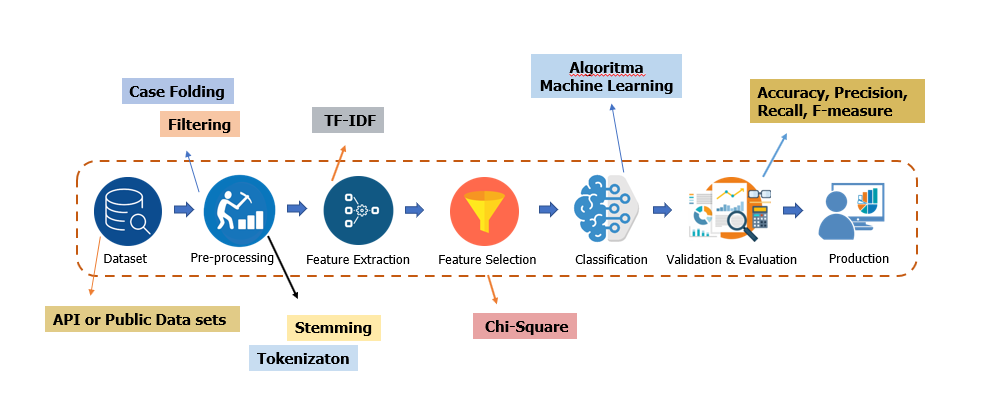

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle
import random

import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to C:\Users\AHMAD
[nltk_data]     ARDHY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [4]:
mkdir ~/.kaggle

The syntax of the command is incorrect.


In [5]:
cp kaggle.json ~/.kaggle/

SyntaxError: invalid syntax (2710861915.py, line 1)

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ashwiniyer176/toxic-tweets-dataset

 90% 2.00M/2.21M [00:01<00:00, 2.23MB/s]
100% 2.21M/2.21M [00:01<00:00, 2.11MB/s]


In [ ]:
! unzip toxic-tweets-dataset.zip

Archive:  toxic-tweets-dataset.zip
  inflating: FinalBalancedDataset.csv  


# 01 Data Acquisition

Penjelasan Label 
* 0: Komentar Bukan Toxic 
* 1: Komentar Toxic

In [2]:
data = pd.read_csv('FinalBalancedDataset.csv')
data.head()

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [3]:
# Shuffle training dataframe
data = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
data.head()

,Unnamed: 0,Toxicity,tweet
44200,44200,1,Kim K is alright but honestly so many niggas b...
46339,46339,0,RT @BigJonBul: The stars wink knowingly and sm...
49169,49169,1,RT @Sassymermaidxo: &#8220;@VSamone: &#8220;@Z...
54130,54130,1,"Those ""tell me about yourself "" lookin ass nig..."
18801,18801,0,4 days ago ... to celebrate #national iced tea...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56745 entries, 44200 to 56422
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.7+ MB


In [5]:
data['Toxicity'].value_counts()

0    32592
1    24153
Name: Toxicity, dtype: int64

In [6]:
data.shape

(56745, 3)

In [7]:
print('Total Jumlah Data:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] Bukan Toxic\t:', data[data.Toxicity == 0].shape[0], 'data')
print('-- [1] Toxic\t:', data[data.Toxicity == 1].shape[0], 'data')

Total Jumlah Data: 56745 data

terdiri dari (label):
-- [0] Bukan Toxic	: 32592 data
-- [1] Toxic	: 24153 data


In [8]:
data['Toxicity'].value_counts()

0    32592
1    24153
Name: Toxicity, dtype: int64

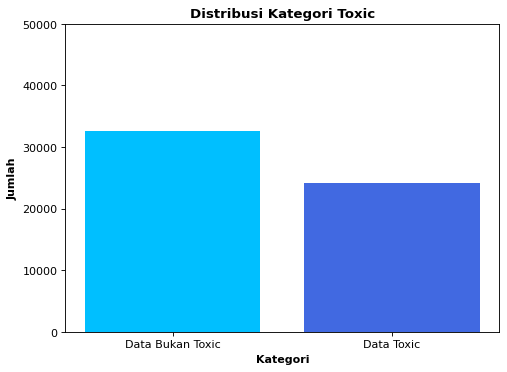

In [9]:
height = data['Toxicity'].value_counts()
labels = ('Data Bukan Toxic', 'Data Toxic')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,5), dpi=80)
plt.ylim(0,50000)
plt.title('Distribusi Kategori Toxic', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [10]:
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    
data['clean_teks'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*")
data

,Unnamed: 0,Toxicity,tweet,clean_teks
44200,44200,1,Kim K is alright but honestly so many niggas b...,Kim K is alright but honestly so many niggas b...
46339,46339,0,RT @BigJonBul: The stars wink knowingly and sm...,RT : The stars wink knowingly and smile at eac...
49169,49169,1,RT @Sassymermaidxo: &#8220;@VSamone: &#8220;@Z...,RT : &#8220;: &#8220;: My sister shittin on yo...
54130,54130,1,"Those ""tell me about yourself "" lookin ass nig...","Those ""tell me about yourself "" lookin ass nig..."
18801,18801,0,4 days ago ... to celebrate #national iced tea...,4 days ago ... to celebrate #national iced tea...
...,...,...,...,...
54343,54343,1,Ummm...so the Happy Fairy apparently took a cr...,Ummm...so the Happy Fairy apparently took a cr...
38158,38158,1,@ivanrabago_ at least put a caption when steal...,at least put a caption when stealing the pic ...
860,860,1,black professor makes assumptions about an ent...,black professor makes assumptions about an ent...
15795,15795,0,#lgbtqhatetrumppay is total #liberal trash. it...,#lgbtqhatetrumppay is total #liberal trash. it...


In [11]:
import re

# Buat fungsi untuk langkah case folding
def clean_text(text):
    text = text.lower()                               # Mengubah teks menjadi lower case
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
    text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
    text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
    text = re.sub(r"(.)\1{2,}",r"\1", text)           # Menghapus duplikasi data
    text = re.sub(r'^RT[\s]+', '', text)
    text = text.strip()
    return text

# Stemming

In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def stemming(text):
    token_words=word_tokenize(text)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

## Filtering (Stopword Removal)

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\AHMAD
[nltk_data]     ARDHY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
more_stopwords = pd.read_csv("english stopwords.csv")
more_stopwords.columns = ['stopwords']

In [15]:
from nltk.corpus import stopwords 
from nltk. tokenize import word_tokenize, sent_tokenize
stop_words = set(stopwords.words('english')) 
additional_sw = set(more_stopwords.stopwords.values)
stop_words = stop_words.union(additional_sw)

def remove_stopwords(text):
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return " ".join(filtered_sentence)

In [16]:
def text_processing(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [17]:
%%time
data['clean_teks'] = data['clean_teks'].apply(text_processing)

# Perhatikan waktu komputasi ketika proses text preprocessing
data

CPU times: total: 26.8 s
Wall time: 27.5 s


,Unnamed: 0,Toxicity,tweet,clean_teks
44200,44200,1,Kim K is alright but honestly so many niggas b...,kim k alright honestli mani nigga id rather mi...
46339,46339,0,RT @BigJonBul: The stars wink knowingly and sm...,rt star wink knowingli smile see two lover kis...
49169,49169,1,RT @Sassymermaidxo: &#8220;@VSamone: &#8220;@Z...,rt sister shittin ho wodeh bout dat action
54130,54130,1,"Those ""tell me about yourself "" lookin ass nig...",tell lookin ass nigga ima crazi bitch that nee...
18801,18801,0,4 days ago ... to celebrate #national iced tea...,day ago celebr nation ice tea day starbuck tea...
...,...,...,...,...
54343,54343,1,Ummm...so the Happy Fairy apparently took a cr...,umso happi fairi appar took crap twitter made ...
38158,38158,1,@ivanrabago_ at least put a caption when steal...,least put caption steal pic fag lol
860,860,1,black professor makes assumptions about an ent...,black professor make assumpt entir race whilst...
15795,15795,0,#lgbtqhatetrumppay is total #liberal trash. it...,lgbtqhatetrumppay total liber trash amp pathet...


In [18]:
data = data.drop_duplicates(subset='clean_teks',keep='first')
data

,Unnamed: 0,Toxicity,tweet,clean_teks
44200,44200,1,Kim K is alright but honestly so many niggas b...,kim k alright honestli mani nigga id rather mi...
46339,46339,0,RT @BigJonBul: The stars wink knowingly and sm...,rt star wink knowingli smile see two lover kis...
49169,49169,1,RT @Sassymermaidxo: &#8220;@VSamone: &#8220;@Z...,rt sister shittin ho wodeh bout dat action
54130,54130,1,"Those ""tell me about yourself "" lookin ass nig...",tell lookin ass nigga ima crazi bitch that nee...
18801,18801,0,4 days ago ... to celebrate #national iced tea...,day ago celebr nation ice tea day starbuck tea...
...,...,...,...,...
54343,54343,1,Ummm...so the Happy Fairy apparently took a cr...,umso happi fairi appar took crap twitter made ...
38158,38158,1,@ivanrabago_ at least put a caption when steal...,least put caption steal pic fag lol
860,860,1,black professor makes assumptions about an ent...,black professor make assumpt entir race whilst...
15795,15795,0,#lgbtqhatetrumppay is total #liberal trash. it...,lgbtqhatetrumppay total liber trash amp pathet...


## Tokenization

In [19]:
# Tokenize kata pada setiap kalimat
def tokenization(text):
  text = re.split('\W+', text)
  return text

sentences = data['clean_teks'].apply(lambda x: tokenization(x.lower()))
sentences

44200    [kim, k, alright, honestli, mani, nigga, id, r...
46339    [rt, star, wink, knowingli, smile, see, two, l...
49169    [rt, sister, shittin, ho, wodeh, bout, dat, ac...
54130    [tell, lookin, ass, nigga, ima, crazi, bitch, ...
18801    [day, ago, celebr, nation, ice, tea, day, star...
                               ...                        
54343    [umso, happi, fairi, appar, took, crap, twitte...
38158        [least, put, caption, steal, pic, fag, lol, ]
860      [black, professor, make, assumpt, entir, race,...
15795    [lgbtqhatetrumppay, total, liber, trash, amp, ...
56422                              [sorri, wrong, bitch, ]
Name: clean_teks, Length: 52344, dtype: object

In [20]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [21]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['Toxicity']

In [22]:
X

44200    kim k alright honestli mani nigga id rather mi...
46339    rt star wink knowingli smile see two lover kis...
49169          rt sister shittin ho wodeh bout dat action 
54130    tell lookin ass nigga ima crazi bitch that nee...
18801    day ago celebr nation ice tea day starbuck tea...
                               ...                        
54343    umso happi fairi appar took crap twitter made ...
38158                 least put caption steal pic fag lol 
860      black professor make assumpt entir race whilst...
15795    lgbtqhatetrumppay total liber trash amp pathet...
56422                                   sorri wrong bitch 
Name: clean_teks, Length: 52344, dtype: object

In [23]:
y

44200    1
46339    0
49169    1
54130    1
18801    0
        ..
54343    1
38158    1
860      1
15795    0
56422    1
Name: Toxicity, Length: 52344, dtype: int64

# Feature Extraction

In [24]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1),
                         stop_words='english',
                        max_features = 1000)
tf_idf.fit(X)

TfidfVectorizer(max_features=1000, stop_words='english')

In [25]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

1000


In [26]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['abl' 'absolut' 'accept' 'account' 'act' 'action' 'actor' 'actual' 'ad'
 'adapt' 'add' 'af' 'affirm' 'afternoon' 'age' 'ago' 'agre' 'ah' 'ahead'
 'aint' 'album' 'aliv' 'allahsoil' 'allow' 'alon' 'alreadi' 'alway' 'amaz'
 'america' 'american' 'amp' 'angri' 'anim' 'anniversari' 'announc' 'annoy'
 'anoth' 'answer' 'anymor' 'anyon' 'anyth' 'app' 'appar' 'appl' 'appreci'
 'arent' 'arriv' 'asian' 'ask' 'ass' 'ate' 'attack' 'attent' 'attitud'
 'aw' 'award' 'away' 'awesom' 'aye' 'babe' 'babi' 'bad' 'bae' 'bag' 'ball'
 'bar' 'base' 'basic' 'bc' 'bday' 'beach' 'bear' 'beat' 'beauti' 'becom'
 'bed' 'beer' 'begin' 'believ' 'best' 'bet' 'better' 'big' 'biggest'
 'bihday' 'bird' 'birthday' 'bit' 'bitch' 'black' 'blame' 'bless' 'block'
 'blog' 'blond' 'blow' 'blue' 'bodi' 'bomb' 'book' 'booti' 'bore' 'boss'
 'bought' 'bout' 'box' 'boy' 'boyfriend' 'break' 'breakfast' 'bring' 'bro'
 'broke' 'broken' 'brother' 'brown' 'browni' 'bruh' 'buffalo' 'build'
 'bull' 'bunch' 'busi' 'buy' 'bye' 'cake' 'came' '

In [27]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,abl,absolut,accept,account,act,action,actor,actual,ad,adapt,...,youll,young,youtub,youv,yr,yu,âï,ðâ,ðð,ó¾
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.496769,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52339,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52340,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52342,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [30]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [31]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 1000
Reduced feature number: 1000


In [32]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,18.475455
1,2.689304
2,3.099205
3,1.674295
4,40.548872
...,...
995,24.576951
996,63.667038
997,25.745204
998,239.249447


In [33]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,18.475455,abl
1,2.689304,absolut
2,3.099205,accept
3,1.674295,account
4,40.548872,act
...,...,...
995,24.576951,yu
996,63.667038,âï
997,25.745204,ðâ
998,239.249447,ðð


In [34]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
88,3517.619537,bitch
396,1730.835365,hoe
719,1474.873833,rt
667,958.945343,pussi
326,784.974230,fuck
...,...,...
567,0.000528,nd
936,0.000190,war
629,0.000108,pictur
29,0.000067,american


In [36]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [37]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['abl',
 'absolut',
 'accept',
 'account',
 'act',
 'action',
 'actor',
 'actual',
 'ad',
 'adapt',
 'add',
 'af',
 'affirm',
 'afternoon',
 'age',
 'ago',
 'agre',
 'ah',
 'ahead',
 'aint',
 'album',
 'aliv',
 'allahsoil',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'amaz',
 'america',
 'american',
 'amp',
 'angri',
 'anim',
 'anniversari',
 'announc',
 'annoy',
 'anoth',
 'answer',
 'anymor',
 'anyon',
 'anyth',
 'app',
 'appar',
 'appl',
 'appreci',
 'arent',
 'arriv',
 'asian',
 'ask',
 'ass',
 'ate',
 'attack',
 'attent',
 'attitud',
 'aw',
 'award',
 'away',
 'awesom',
 'aye',
 'babe',
 'babi',
 'bad',
 'bae',
 'bag',
 'ball',
 'bar',
 'base',
 'basic',
 'bc',
 'bday',
 'beach',
 'bear',
 'beat',
 'beauti',
 'becom',
 'bed',
 'beer',
 'begin',
 'believ',
 'best',
 'bet',
 'better',
 'big',
 'biggest',
 'bihday',
 'bird',
 'birthday',
 'bit',
 'bitch',
 'black',
 'blame',
 'bless',
 'block',
 'blog',
 'blond',
 'blow',
 'blue',
 'bodi',
 'bomb',
 'book',
 'booti',
 'bore',
 'boss',


In [38]:
# Cara melihat vocab yang dihasilkan oleh tf_idf
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [39]:
kbest_feature

{'mani': 519,
 'nigga': 576,
 'id': 415,
 'got': 354,
 'bitch': 88,
 'rt': 719,
 'star': 800,
 'smile': 777,
 'kiss': 456,
 'nig': 575,
 'sister': 767,
 'ho': 395,
 'bout': 104,
 'dat': 203,
 'action': 5,
 'tell': 852,
 'lookin': 500,
 'ass': 49,
 'ima': 422,
 'crazi': 186,
 'need': 568,
 'know': 458,
 'day': 206,
 'ago': 15,
 'celebr': 136,
 'nation': 564,
 'ice': 414,
 'tea': 846,
 'offer': 587,
 'im': 421,
 'ladi': 460,
 'bc': 68,
 'voic': 928,
 'scare': 729,
 'speak': 792,
 'mind': 538,
 'wait': 931,
 'isnt': 435,
 'amp': 30,
 'hey': 389,
 'guy': 364,
 'appar': 42,
 'white': 955,
 'black': 89,
 'peopl': 617,
 'thing': 864,
 'nice': 574,
 'histori': 393,
 'racist': 676,
 'look': 499,
 'blue': 96,
 'feel': 294,
 'red': 693,
 'good': 349,
 'small': 774,
 'food': 313,
 'bar': 65,
 'travel': 890,
 'dyke': 245,
 'like': 483,
 'ive': 437,
 'alway': 26,
 'wonder': 964,
 'model': 542,
 'friday': 323,
 'yay': 980,
 'follow': 311,
 'set': 746,
 'littl': 490,
 'miss': 540,
 'natur': 565,
 'fat

In [40]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,abl,absolut,accept,account,act,action,actor,actual,ad,adapt,...,youll,young,youtub,youv,yr,yu,âï,ðâ,ðð,ó¾
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.496769,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52339,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52340,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52342,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
with open('kbest_feature.pickle', 'wb') as output:
    pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

In [42]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [43]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [44]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [45]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [46]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

# 05 Model Evaluation

In [47]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 9396
Jumlah prediksi salah	: 1073
Akurasi pengujian	: 89.75069252077562 %


In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[5304  573]
 [ 500 4092]]


In [49]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      5877
           1       0.88      0.89      0.88      4592

    accuracy                           0.90     10469
   macro avg       0.90      0.90      0.90     10469
weighted avg       0.90      0.90      0.90     10469



In [50]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.8921578  0.8940682  0.89397268 0.89836661 0.89378164 0.89339956
 0.89330404 0.89569204 0.89445028 0.89874869] 

Rata-rata akurasi pada cross validation: 0.8947941541694526


# 06 Simple Deployment


In [51]:
from joblib import load

# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [52]:
#@title Masukkan Teks Anda:
input_text = input("Masukkan Kalimat yang ingin dideteksi: ")

pre_input_text = text_processing(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('\nHasil Text Preprocessing :', pre_input_text)

if (result==0):
  teks = 'Kalimat BUKAN TOXIC'
elif (result==1):
  teks = 'Kalimat TOXIC'
else:
  teks = 'TIDAK DIKENALI'

print('\nHasil prediksi: ', input_text, ' adalah ', teks)


Hasil Text Preprocessing : 

Hasil prediksi:  what are you doing here  adalah  Kalimat BUKAN TOXIC


In [53]:
input_text = input("Masukkan Kalimat yang ingin dideteksi: ")

pre_input_text = text_processing(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('\nHasil Text Preprocessing :', pre_input_text)

if (result==0):
  sms = 'Kalimat BUKAN TOXIC'
elif (result==1):
  sms = 'Kalimat TOXIC'
else:
  sms = 'TIDAK DIKENALI'

print('\nHasil prediksi: ', input_text, ' adalah ', sms)


Hasil Text Preprocessing : fuck 

Hasil prediksi:  fuck you  adalah  Kalimat TOXIC


In [54]:
# save the model to disk
dump(model, filename="model_toxic_tfidf_nb.model")

['model_toxic_tfidf_nb.model']